In [122]:
import os
import argparse
import time
import torch
from torchvision import transforms
from cvtorchvision import cvtransforms
import cv2
import random
from torchsat.transforms import transforms_cls
from bigearthnet_dataset_seco_lmdb import LMDBDataset
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data_dir = '/p/project/hai_dm4eo/wang_yi/data/BigEarthNet'

In [6]:
class GaussianBlur(object):
#Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709


    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        #x = x.filter(ImageFilter.GaussianBlur(radius=sigma))

        return cv2.GaussianBlur(x,(3,3),sigma)


class RandomChannelDrop(object):
    """ Random Channel Drop """

    def __init__(self, min_n_drop=1, max_n_drop=8):
        self.min_n_drop = min_n_drop
        self.max_n_drop = max_n_drop

    def __call__(self, sample):
        n_channels = random.randint(self.min_n_drop, self.max_n_drop)
        channels = np.random.choice(range(sample.shape[0]), size=n_channels, replace=False)

        for c in channels:
            sample[c, :, :] = 0.        
        return sample

In [157]:
class RandomBrightness(object):
    """ Random Brightness """
    
    def __init__(self, brightness=0.4):
        self.brightness = brightness

    def __call__(self, sample):
        s = np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness)
        img = sample * s
        
        return img.astype(np.uint8)
    
class RandomContrast(object):
    """ Random Contrast """
    
    def __init__(self, contrast=0.4):
        self.contrast = contrast

    def __call__(self, sample):
        s = np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast)
        mean = np.mean(sample, axis=(0, 1))
        
        return ((sample - mean) * s + mean).astype(np.uint8)
    
class ToGray(object):
    def __init__(self, out_channels):
        self.out_channels = out_channels
    def __call__(self,sample):
        gray_img = np.mean(sample, axis=-1)
        gray_img = np.tile(gray_img, (self.out_channels, 1, 1))
        gray_img = np.transpose(gray_img, [1, 2, 0])
        return gray_img.astype(np.uint8)


In [186]:
augmentation = [
    #cvtransforms.Resize((128, 128)),
    cvtransforms.RandomResizedCrop(112, scale=(0.2, 1.)),
    cvtransforms.RandomApply([
        RandomBrightness(0.4),
        RandomContrast(0.4)
    ], p=0.8),
    cvtransforms.RandomApply([ToGray(12)], p=0.8),
    cvtransforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    cvtransforms.RandomHorizontalFlip(),
    cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=8)], p=0.5),
    #cvtransforms.ToTensor(),
    #normalize
]

In [187]:
train_transforms = cvtransforms.Compose(augmentation)

In [188]:
train_dataset = LMDBDataset(
    lmdb_file=os.path.join(data_dir, 'train_B12.lmdb'),
    transform=train_transforms
)

In [189]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, num_workers=0)

0 torch.Size([2, 112, 112, 12]) tensor(235, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
1 torch.Size([2, 112, 112, 12]) tensor(203, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


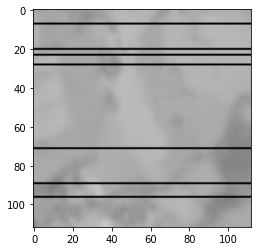

In [190]:
for idx, (img,target) in enumerate(train_loader):
    if idx>1:
        break
    print(idx, img.shape, img.max(), img.min())
    plt.imshow(img[0,:,:,1:4])

In [70]:
img.shape

torch.Size([2, 112, 112, 12])

In [42]:
i1 = cvtransforms.RandomResizedCrop(112, scale=(0.2, 1.))(img[0])


AssertionError: img should be CV Image